# GPT vs Traditional Models Performance for Tasks

**Aim:**  This notebook compares the performance of GPT-based models and traditional machine learning models across various NLP tasks such as sentiment analysis, text summarization, and classification. It evaluates models on metrics like accuracy, precision, recall, F1-score, and latency, providing a clear comparison of modern LLM capabilities versus classical approaches. The notebook highlights strengths, limitations, and practical considerations for choosing the appropriate model for different tasks.

### Table of Contents
1. [Sentiment Analysis](#section1)             
    1.1 [Importing Libraries and Loading Dataset](#subsection1)   
    1.2 [Text Preprocessing](#subsection2)                    
    1.3 [Text Vectorisation](#subsection3)                       
    1.4 [Traditional Model Training and Evaluation](#subsection4)                
    1.5 [Hyperparameter Tuning Logistic Regression and SVM](#subsection5)                 
    1.6 [Traditional Model Visualisation and Insights](#subsection6)               
    1.7 [Transformer Based Model training](#subsection7)              
    1.8 [Transformer Based Model Evaluation](#subsection8)                                
    1.9 [Transformer Based Model Visualisation](#subsection9)          
2. [Text Summarisation](#section2)                                     
    2.1 [Importing Libraries and Loading Dataset](#subsection10)        
    2.2 [Traditional Text Summarisation using Sumy](#subsection11)                
    2.3 [Transformer Based Model Text Summarisation](#subsection12)              
    2.4 [Evalaution of Tranditional and Transformer Models](#subsection13)           
    2.5 [Visualisation and Insights](#subsection14)           
 

## 1. Sentiment Analysis <a id="section1"></a>

Compare the predictions of Sentiment Analysis by both Traditonal NLP Technique as well as using BERT Model 

### 1.1 Importing Necessary Libraries <a id="subsection1"></a>

In [8]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import unidecode
import spacy 
import tqdm as notebook_tqdm
from spacy.lang.en.stop_words import STOP_WORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack, csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
from datasets import load_dataset
dataset = load_dataset("amazon_polarity")  


In [3]:
# Convert the training split to a Pandas DataFrame
df_train = dataset["train"].to_pandas()  

df_train.head()

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [4]:
# Convert the test split to Pandas DataFrame
df_test = dataset["test"].to_pandas()

df_test.head()

,label,title,content
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


### 1.2 Text Preprocessing <a id="subsection2"></a>


In [5]:
# Intialising Lemmatizer and stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words("english")

# Defining a preprocessor of data cleaning
def preprocessor(tweet):
    
    # Removal of user handles
    tweet = re.sub('@[\w\-]+','', tweet)
    
    # Coverting the string into lower case
    tweet = str(tweet).lower()
    
    tweet = re.sub('\[.*?\]','',tweet)
    
    # Removal of HTML linkups
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    
    # Removal of punctuations
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub('\n','',tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    
    # Removal of stopwords
    tweet = [word for word in tweet.split(' ') if word not in stopwords]
    
    #removal of greek characters
    tweet = [' '.join([unidecode.unidecode(word) for word in str(t).split()]) if t is not None else t for t in tweet]
    
    #lemmetizing of tweets
    tweet = [" ".join(lemmatizer.lemmatize(word) for word in t.split()) for t in tweet]
    
    tweet = " ".join(tweet)
    return tweet

In [6]:
# Sampling test_df
df_test_sample = df_test.sample(n=50000, random_state=101) 

In [7]:
df_test_sample.shape

(50000, 3)

In [8]:
# Sampling train_df
df_train_sample = df_train.sample(n=100000, random_state=42)  # Random sample

In [9]:
df_train_sample.shape

(100000, 3)

In [10]:
# Applying Clean function to the train content present in the dataset
df_train_sample['cleaned_content_tr'] = df_train_sample['content'].apply(preprocessor)

In [11]:
df_test_sample['cleaned_content_ts'] = df_test_sample['content'].apply(preprocessor)

In [ ]:
# Saving Preprocesed data to csv
df_train_sample.to_csv("df_train_sample.csv", index = False)
df_test_sample.to_csv("df_test_sample.csv", index = False)

In [9]:
df_train_sample = pd.read_csv("df_train_sample.csv")
df_test_sample = pd.read_csv("df_test_sample.csv")

In [10]:
# VADER sentiment score function
analyzer = SentimentIntensityAnalyzer()

def vader_score(text):
    return analyzer.polarity_scores(str(text))['compound']

df_train_sample['vader_compound_tr'] = df_train_sample['cleaned_content_tr'].apply(vader_score)
df_test_sample['vader_compound_ts'] = df_test_sample['cleaned_content_ts'].apply(vader_score)

### 1.3 Text Vectorization <a id="subsection3"></a>

In [11]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(df_train_sample['cleaned_content_tr'])
X_test_tfidf = vectorizer.transform(df_test_sample['cleaned_content_ts'])

In [12]:
#scalng vader scores as models dont take negative inputs
df_train_sample['vader_compound_tr'] = (df_train_sample['vader_compound_tr'] + 1) / 2
df_test_sample['vader_compound_ts'] = (df_test_sample['vader_compound_ts'] + 1) / 2


In [15]:

# Convert VADER columns to sparse matrices
vader_train_sparse = csr_matrix(df_train_sample['vader_compound_tr'].values.reshape(-1, 1))
vader_test_sparse = csr_matrix(df_test_sample['vader_compound_ts'].values.reshape(-1, 1))

# Combine sparse TF-IDF and VADER score
X_train_final = hstack((X_train_tfidf, vader_train_sparse))
X_test_final = hstack((X_test_tfidf, vader_test_sparse))

y_train = df_train_sample['label']
y_test = df_test_sample['label']


In [14]:

X_train_final = X_train_tfidf
X_test_final = X_test_tfidf

y_train = df_train_sample['label']
y_test = df_test_sample['label']

### 1.4 Traditional Model Training & Evaluation <a id="subsection4"></a>

In [14]:
# Model
model = MultinomialNB()
model.fit(X_train_final, y_train)

MultinomialNB()

In [35]:
# Predict and evaluate
y_pred = model.predict(X_test_final)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     25110
           1       0.82      0.82      0.82     24890

    accuracy                           0.82     50000
   macro avg       0.82      0.82      0.82     50000
weighted avg       0.82      0.82      0.82     50000



In [16]:
# use of Logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_final, y_train)

LogisticRegression()

In [17]:
y_pred_lr = lr.predict(X_test_final)
sentiment_tra = pd.DataFrame(y_pred_lr)
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85     25110
           1       0.85      0.86      0.85     24890

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



In [18]:
sentiment_tra['y_test'] = df_test_sample['label']

In [19]:
sentiment_tra = sentiment_tra.rename(columns={0: "y_pred"})  
sentiment_tra.head()

,y_pred,y_test
0,0,1
1,1,1
2,1,1
3,1,1
4,1,1


In [20]:
sentiment_tra.to_csv("Sentiment_prediction_tra.csv", index = False)

In [29]:
report_sa_tra = classification_report(y_test,y_pred_lr, output_dict=True)

# Convert to DataFrame
df_report_sa_tra = pd.DataFrame(report_sa_tra).transpose()

df_report_sa_tra = df_report_sa_tra[df_report_sa_tra.index.astype(str).str.isdigit()]
df_report_sa_tra = df_report_sa_tra.apply(pd.to_numeric, errors='coerce')
# Save to CSV
df_report_sa_tra.to_csv("CR_Sentiment_trasitional.csv", index=True)


In [30]:
print(df_report_sa_tra)

   precision    recall  f1-score  support
0   0.858370  0.847909  0.853107  25110.0
1   0.848428  0.858859  0.853612  24890.0


In [17]:
# Model Training using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train)
y_pred_rf = rf_model.predict(X_test_final)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))


KeyboardInterrupt: 

In [17]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Report:\n", classification_report(y_test, y_pred_svm))


SVM Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85     25110
           1       0.85      0.85      0.85     24890

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



In [26]:
# exporting the vectoriser and classfier
import joblib

# vectorizer
joblib.dump(vectorizer, "models/tfidf_vectorizer.joblib")

# Classifiers
joblib.dump(lr, "models/logistic_clf.joblib")
#joblib.dump(svm_model, "models/svm_clf.joblib")



['models/logistic_clf.joblib']

In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_model.predict(X_test_tfidf)

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))


C:\Users\Krishnapriya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82     25110
           1       0.82      0.82      0.82     24890

    accuracy                           0.82     50000
   macro avg       0.82      0.82      0.82     50000
weighted avg       0.82      0.82      0.82     50000



### 1.5 Hyperparameter Tuning Logistic Regression and SVM <a id="subsection5"></a>

In [21]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}

# Instantiate model
lr = LogisticRegression(max_iter=1000)

# Grid search
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train_tfidf, y_train)

# Best model and evaluation
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

from sklearn.metrics import classification_report
print("Best Logistic Regression Params:", grid_search_lr.best_params_)
print("Tuned Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Tuned Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85     25110
           1       0.85      0.85      0.85     24890

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



In [22]:
# SVM
from sklearn.svm import LinearSVC

param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge']
}

svc = LinearSVC(max_iter=2000)

grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_svc.fit(X_train_tfidf, y_train)

best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test_tfidf)

print("Best SVM Params:", grid_search_svc.best_params_)
print("Tuned SVM Report:\n", classification_report(y_test, y_pred_svc))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best SVM Params: {'C': 0.1, 'loss': 'squared_hinge'}
Tuned SVM Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86     25110
           1       0.85      0.86      0.85     24890

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



### 1.6 Traditional Model Visualisation and Insights <a id="subsection6"></a>

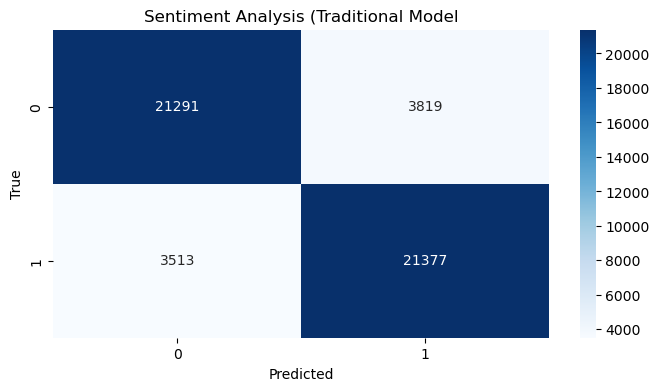

In [25]:
# confuion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_mat(y_test,y_pred, title):
    cm = confusion_matrix(y_test, y_pred, labels = sorted(set(y_test)))
    plt.figure(figsize = (8, 4))
    sns.heatmap(cm, annot=True, fmt ='d', xticklabels = sorted(set(y_test)), yticklabels=sorted(set(y_test)), cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion_mat(sentiment_tra['y_test'], sentiment_tra['y_pred'], "Sentiment Analysis (Traditional Model")

#### Insights
- Accuracy of the Model: 85%
- High Overall Accuracy: The model correctly classified a large majority of the samples. The high numbers on the main diagonal (21,291 True Negatives and 21,377 True Positives) indicate it performs well at identifying both negative and positive sentiments.

- Balanced Performance: The model shows no significant bias towards one class. The number of misclassifications for negative sentiments (3,819 False Positives) is similar to the misclassifications for positive sentiments (3,513 False Negatives).

- Predictable Error Types: The model's primary weaknesses are misclassifying positive sentiments as negative and negative sentiments as positive, with a total of 7,332 errors.

- Strong Metrics: The precision and recall scores for both classes are high (above 84%), which confirms that the model is both accurate in its positive predictions and effective at finding most of the positive cases.

### 1.7 Transformer Based Model Training for Sentiment Analysis <a id="subsection7"></a>
**Why Use Transformer-Based Models?**   
Traditional ML (e.g., Naive Bayes, SVM) and even LSTMs struggle with understanding context. Transformers like BERT solve this by using self-attention, and are pretrained on massive corpora—so they "understand" language better.

In [2]:
import warnings
warnings.filterwarnings('ignore')  

In [10]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Model name
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create the pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer
)

# Example usage
text = "I absolutely loved this product! It's fantastic."
result = sentiment_pipeline(text)
print(result)

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998831748962402}]


In [11]:
# Save model and tokenizer
model.save_pretrained("models/transformer_sentiment")
tokenizer.save_pretrained("models/transformer_sentiment")

('models/transformer_sentiment\\tokenizer_config.json',
 'models/transformer_sentiment\\special_tokens_map.json',
 'models/transformer_sentiment\\vocab.txt',
 'models/transformer_sentiment\\added_tokens.json',
 'models/transformer_sentiment\\tokenizer.json')

In [22]:
import pandas as pd
import tqdm


df = pd.read_csv("df_train_sample.csv")  


In [13]:
# Train Clasification

from tqdm import tqdm

# Convert to list
texts = df['cleaned_content_tr'].tolist()

# Process in batches
batch_size = 32
sentiments = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    results = sentiment_pipeline(batch)
    sentiments.extend([res['label'] for res in results])

# Assign back to DataFrame
df['sentiment'] = sentiments


100%|████████████████████████████████████████████████████████████████████████████| 3125/3125 [3:09:05<00:00,  3.63s/it]


In [5]:
df_test = pd.read_csv("df_test_sample.csv")

In [6]:
# Test classification

# Convert to list
from tqdm import tqdm
texts = df_test['cleaned_content_ts'].tolist()

# Process in batches
batch_size = 32
sentiments = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    results = sentiment_pipeline(batch)
    sentiments.extend([res['label'] for res in results])

# Assign back to DataFrame
df_test['sentiment'] = sentiments


100%|████████████████████████████████████████████████████████████████████████████| 1563/1563 [2:15:11<00:00,  5.19s/it]


In [7]:
df_test.to_csv("LLM_sentiment_ts.csv", index = False)

In [15]:
df.to_csv("LLM_sentiment_tr.csv", index = False)

In [6]:
df_train['sentiment'].value_counts()

sentiment
0    62610
1    37390
Name: count, dtype: int64

### 1.8 Transformer Model Evaluation <a id="subsection8"></a>

In [38]:
import pandas as pd
df_test = pd.read_csv("LLM_sentiment_ts.csv")


In [39]:
df_test['sentiments_label'] = df_test['sentiment'].map({"POSITIVE":1, "NEGATIVE":0})

In [40]:
df_test.head()

,label,title,content,cleaned_content_ts,sentiment,sentiments_label
0,1,Unbelievable,When I read this book I had to keep reminding ...,read book keep reminding real person fictional...,POSITIVE,1
1,1,"Thank You, Al Franken!","I know if you're a conservative, you'll think ...",know youre conservative youll think another li...,NEGATIVE,0
2,1,Funny!,I love this movie. Can't say that enough. Rick...,love movie cant say enough rick moranis federa...,POSITIVE,1
3,1,Limbo is pure storytelling.,"When I first saw Sayles film ""Lone Star,"" it t...",first saw sayles film lone star touched level ...,POSITIVE,1
4,1,Lovely performance,"It is one of the greatest operas, the producti...",one greatest opera production fine singer orch...,POSITIVE,1


In [31]:
sentiment_gpt = df_test[['label', 'sentiments_label']].copy()
sentiment_gpt.to_csv("Sentiment_prediction_gpt.csv", index = False)

In [32]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
# Now calculate metrics with consistent label types
accuracy = accuracy_score(df_test['label'], df_test['sentiments_label'])
report = classification_report(df_test['label'], df_test['sentiments_label'],
                              target_names=['POSITIVE', 'NEGATIVE'])  # Match original label order

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.7772

Classification Report:
              precision    recall  f1-score   support

    POSITIVE       0.72      0.90      0.80     25110
    NEGATIVE       0.87      0.65      0.74     24890

    accuracy                           0.78     50000
   macro avg       0.80      0.78      0.77     50000
weighted avg       0.80      0.78      0.77     50000



In [31]:
report_sa_gpt = classification_report(df_test['label'], df_test['sentiments_label'], output_dict=True)

# Convert to DataFrame
df_report_sa_gpt = pd.DataFrame(report_sa_gpt).transpose()

df_report_sa_gpt = df_report_sa_gpt[df_report_sa_gpt.index.astype(str).str.isdigit()]

df_report_sa_gpt = df_report_sa_gpt.apply(pd.to_numeric, errors='coerce')

# Save to CSV
df_report_sa_gpt.to_csv("CR_Sentiment_GPT.csv", index=True)



In [26]:
df_train = pd.read_csv("LLM_sentiment_tr.csv")
df_train['Sentiment_label'] = df_train['sentiment'].map({1: "POSITIVE", 0: "NEGATIVE"})
df_train.head()

,label,title,content,cleaned_content_tr,sentiment,Sentiment_label
0,0,Expensive Junk,This product consists of a piece of thin flexi...,product consists piece thin flexible insulatin...,0,NEGATIVE
1,0,Toast too dark,"Even on the lowest setting, the toast is too d...",even lowest setting toast dark liking also lig...,0,NEGATIVE
2,1,Excellent imagery...dumbed down story,I enjoyed this disc. The video is stunning. I ...,enjoyed disc video stunning agree others story...,1,POSITIVE
3,0,Are we pretending everyone is married?,The authors pretend that parents neither die n...,author pretend parent neither die divorce insi...,0,NEGATIVE
4,0,Not worth your time,"Might as well just use a knife, this product h...",might well use knife product hold next nothing...,0,NEGATIVE


In [29]:
from sklearn.metrics import classification_report, accuracy_score
#Calculate train accuracy
accuracy = accuracy_score(df_train['label'], df_train['sentiment'])
report = classification_report(df_train['label'], df_train['sentiment'],
                              target_names=['POSITIVE', 'NEGATIVE'])  # Match original label order

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.7783

Classification Report:
              precision    recall  f1-score   support

    POSITIVE       0.72      0.90      0.80     50013
    NEGATIVE       0.87      0.65      0.75     49987

    accuracy                           0.78    100000
   macro avg       0.80      0.78      0.77    100000
weighted avg       0.80      0.78      0.77    100000



### 1.9 Transformer Based Model Visualisation <a id="subsection9"></a>

In [34]:
df_test['Sentiment_label'] = df_test['sentiment'].map({1: "POSITIVE", 0: "NEGATIVE"})

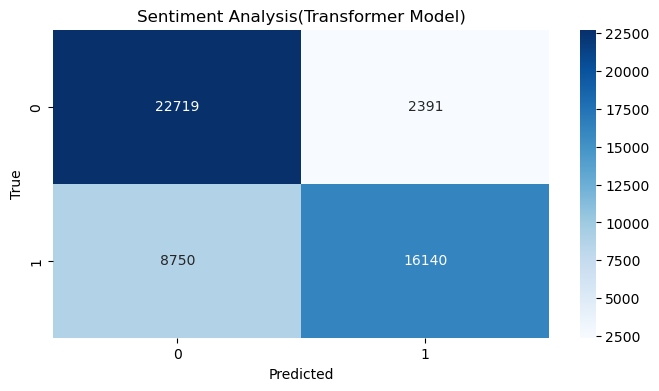

In [42]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_mat(y_true,y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels = sorted(set(y_true)))
    plt.figure(figsize = (8, 4))
    sns.heatmap(cm, annot=True, fmt ='d', xticklabels = sorted(set(y_true)), yticklabels=sorted(set(y_true)), cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion_mat(df_test['label'], df_test['sentiments_label'], "Sentiment Analysis(Transformer Model)")

### Insights 
- Accuracy of the model: 78%
- Strong Overall Performance: The transformer model correctly classified a large majority of the samples. The high numbers on the main diagonal (22,719 True Negatives and 16,140 True Positives) indicate it performs well at identifying both negative and positive sentiments.

- Significantly More Errors on Positive Class: The model struggles more with correctly identifying positive sentiments than negative ones. There are a very high number of False Negatives (8,750), which means the model frequently misclassified positive sentiment as negative. This is a significant imbalance compared to the False Positives (2,391).

- Bias Towards Negative Prediction: The model appears to be biased towards predicting a negative outcome. It is much more likely to incorrectly label a positive text as negative than it is to incorrectly label a negative text as positive. This is the opposite of the Traditional model you showed previously.

- Superior Performance on Negative Class: When compared to the previous "Traditional Model" confusion matrix, this transformer model shows a noticeably better performance in correctly identifying negative sentiments, with fewer false positives (2,391 vs 3,819). However, it performs worse on the positive class, with a higher number of false negatives (8,750 vs 3,513).

## 2. Text Summarization <a id="section2"></a>
Comparing Text summarization results produced by traditional and Transformer Based Model.

### 2.1 Importing Necessary Libraries and Loading Dataset <a id="subsection10"></a>

In [23]:
# importing necessary libraries
import pandas as pd
import numpy as np
import nltk
import sumy


In [24]:
# Importing the datasets

from datasets import load_dataset

# Load a small sample of the dataset for testing
dataset = load_dataset("cnn_dailymail", '3.0.0', split='train[:100]')



In [25]:
# Printing the dataset
print(dataset[0])

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [26]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

article = dataset[0]['article']
summary = dataset[0]['highlights']

sentences = sent_tokenize(article)
print(sentences[:5])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Krishnapriya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


["LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him.", 'Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.', '"I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.', '"I don\'t think I\'ll be particularly extravagant.', '"The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."']


### 2.2 Traditional Text summarisation using Sumy <a id="subsection11"></a>

In [4]:
# applying Extractive summarization
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

def textrank_summary(text, num_sentences=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join(str(sentence) for sentence in summary)

# Example usage
extractive_summary = textrank_summary(article, num_sentences=3)
print("Extractive Summary:\n", extractive_summary)


Extractive Summary:
 Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. His latest outing as the boy wizard in "Harry Potter and the Order of the Phoenix" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films.


In [11]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(summary, extractive_summary)

print("ROUGE Scores:\n", scores)


ROUGE Scores:
 {'rouge1': Score(precision=0.19491525423728814, recall=0.5897435897435898, fmeasure=0.2929936305732484), 'rouge2': Score(precision=0.1111111111111111, recall=0.34210526315789475, fmeasure=0.16774193548387095), 'rougeL': Score(precision=0.15254237288135594, recall=0.46153846153846156, fmeasure=0.22929936305732485)}


### 2.3 Transformer-based model/ GPT based model for text Summarisation <a id="section12"></a>

In [13]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_data = dataset["train"].select(range(100))  # use 100 samples for quick testing


In [1]:
# Import Transformer Model
from transformers import BartTokenizer, BartForConditionalGeneration

# Intialise Bart tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")


In [2]:
# saving the models
model.save_pretrained("transformer_summarizer")
tokenizer.save_pretrained("transformer_summarizer")

C:\Users\Krishnapriya\anaconda3\Lib\site-packages\transformers\modeling_utils.py:3852: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('transformer_summarizer\\tokenizer_config.json',
 'transformer_summarizer\\special_tokens_map.json',
 'transformer_summarizer\\vocab.json',
 'transformer_summarizer\\merges.txt',
 'transformer_summarizer\\added_tokens.json')

In [7]:
# tokeniser articles
article = train_data[0]['article']

# tokenising the article data
inputs = tokenizer([article], max_length = 1024, return_tensors='pt', truncation = True)

In [8]:
# Generate summary using model
summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)


Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund.


### 2.4 Evaluation for Text summarisation for Traditional model <a id="section13"></a>

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Cosine Similarity for Content Relevance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Intialize Vectoriser
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([article,extractive_summary])
similarity_score = cosine_similarity(vectors[0:1], vectors[1:2])
print("Tfidf Cosine Similarity:", round(similarity_score[0][0],2))

vector_2 = vectoriser.fit_transform([article, summary])
simmlarity_score_2 = cosine_similarity(vector_2[0:1], vector_2[1:2])



Tfidf Cosine Similarity: 0.74


In [8]:
# Sentence Transformer Embeddings for better semantic similarity

from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode([article, extractive_summary], convert_to_tensor = True)
score = util.cos_sim(embeddings[0], embeddings[1])
print("Semantic Similarity:", score.item())

embe

Semantic Similarity: 0.8152716159820557


**Flesch reading ease:** A measure of how easy or difficult a piece of text is to understand. A higher score (closer to 100) indicates easier readability, while a lower score (closer to 0) suggests more complex text.   


In [9]:
# TextStat Readability scores
import textstat

flesch_score = textstat.flesch_reading_ease(extractive_summary)
print("Flesch Reading Ease Score:", round(flesch_score,2))

Flesch Reading Ease Score: 47.18


In [10]:
# Grammer Score using language tool python
# Grammar check
import language_tool_python

def grammar_score(text):
    tool = language_tool_python.LanguageTool('en-GB')
    matches = tool.check(text)
    error_count = len(matches)
    word_count = len(text.split())
    score = (1 - error_count / word_count) * 100 if word_count > 0 else 0.0
    return round(score, 3)

print("Grammar Score:", grammar_score(extractive_summary))

Grammar Score: 99.153


In [11]:
# Lexical Diversity

def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words)

print("Lexical Diversity:", lexical_diversity(extractive_summary))

Lexical Diversity: 0.6779661016949152


In [12]:
# Compress Ratio - Helps understand if the summary is long or short

compression_ratio = len(extractive_summary.split())/len(article.split())

print("Compression Ratio:", compression_ratio)


Compression Ratio: 0.25934065934065936


In [17]:
# Sentiment Consistency - Sentiment of the summary matches the article
from textblob import TextBlob 

article_sentiment = TextBlob(article).sentiment.polarity
summary_sentiment = TextBlob(extractive_summary).sentiment.polarity

print("Article Sentiment:", round(article_sentiment,2))
print("Summary Sentiment:", round(summary_sentiment,2))

Article Sentiment: 0.09
Summary Sentiment: 0.1


In [20]:
# Repetition and Redundancy
from collections import Counter

def repetition_score(text):
    words = text.lower().split()
    words_count = Counter(words)
    repeated = [count for word, count in words_count.items() if count > 1]
    return sum(repeated) / len(words)

print("Repetition Score:", repetition_score(extractive_summary))

Repetition Score: 0.4830508474576271


In [37]:
# Initialize the result storage DataFrame
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from textblob import TextBlob 
import language_tool_python
import textstat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
model = SentenceTransformer('all-MiniLM-L6-v2')

evaluation_df = pd.DataFrame(columns=[
    'article', 'summary',
    'tfidf_similarity',
    'semantic_similarity',
    'lexical_diversity',
    'compression_ratio',
    'article_sentiment',
    'summary_sentiment',
    'sentiment_diff',
    'repetition_score',
    'readability_score',
    'model_used'
])

def evaluate_summary(article, summary, model_type='Unknown'):
    global evaluation_df  # to keep appending results

    # TF-IDF Cosine Similarity
    tfidf_vectorizer = TfidfVectorizer()
    vectors = tfidf_vectorizer.fit_transform([article, summary])
    tfidf_score = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]

    # Semantic Similarity using SBERT
    embeddings = model.encode([article, summary], convert_to_tensor=True)
    semantic_score = util.cos_sim(embeddings[0], embeddings[1]).item()

    # Lexical Diversity
    words = summary.split()
    lex_div = len(set(words)) / len(words) if words else 0

    # Compression Ratio
    compress = len(summary.split()) / len(article.split()) if article.split() else 0

    # Sentiment Polarity
    sentiment_article = TextBlob(article).sentiment.polarity
    sentiment_summary = TextBlob(summary).sentiment.polarity
    sentiment_diff = abs(sentiment_article - sentiment_summary)

    # Repetition Score
    word_counts = Counter([w.lower() for w in words])
    repeated = [count for word, count in word_counts.items() if count > 1]
    repeat_score = sum(repeated) / len(words) if words else 0

    # Readability
    readability = textstat.flesch_reading_ease(summary)
    readability_score = readability/100

    # Final result row
    row = {
        'article': article,
        'summary': summary,
        'tfidf_similarity': tfidf_score,
        'semantic_similarity': semantic_score,
        'lexical_diversity': lex_div,
        'compression_ratio': compress,
        'article_sentiment': sentiment_article,
        'summary_sentiment': sentiment_summary,
        'sentiment_diff': sentiment_diff,
        'repetition_score': repeat_score,
        'readability_score': readability_score,
        'model_used': model_type
    }

    # Append to DataFrame
    evaluation_df = pd.concat([evaluation_df, pd.DataFrame([row])], ignore_index=True)
    


In [38]:
evaluate_summary(article, extractive_summary, model_type="Traditional")


In [39]:
evaluate_summary(article,summary, model_type = "GPT")

In [40]:
evaluation_df.to_csv("Text_summarise_metrics.csv")

In [42]:
evaluation_df.head()

,article,summary,tfidf_similarity,semantic_similarity,lexical_diversity,compression_ratio,article_sentiment,summary_sentiment,sentiment_diff,repetition_score,readability_score,model_used
0,"LONDON, England (Reuters) -- Harry Potter star...","Daniel Radcliffe as Harry Potter in ""Harry Pot...",0.743093,0.815272,0.677966,0.259341,0.094684,0.10,0.005316,0.483051,0.471812,Traditional
1,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe turns 18 on...,0.373150,0.785261,0.942857,0.076923,0.094684,0.25,0.155316,0.114286,0.770966,GPT


### 2.5 Visualisation and Insights <a id="section14"></a>

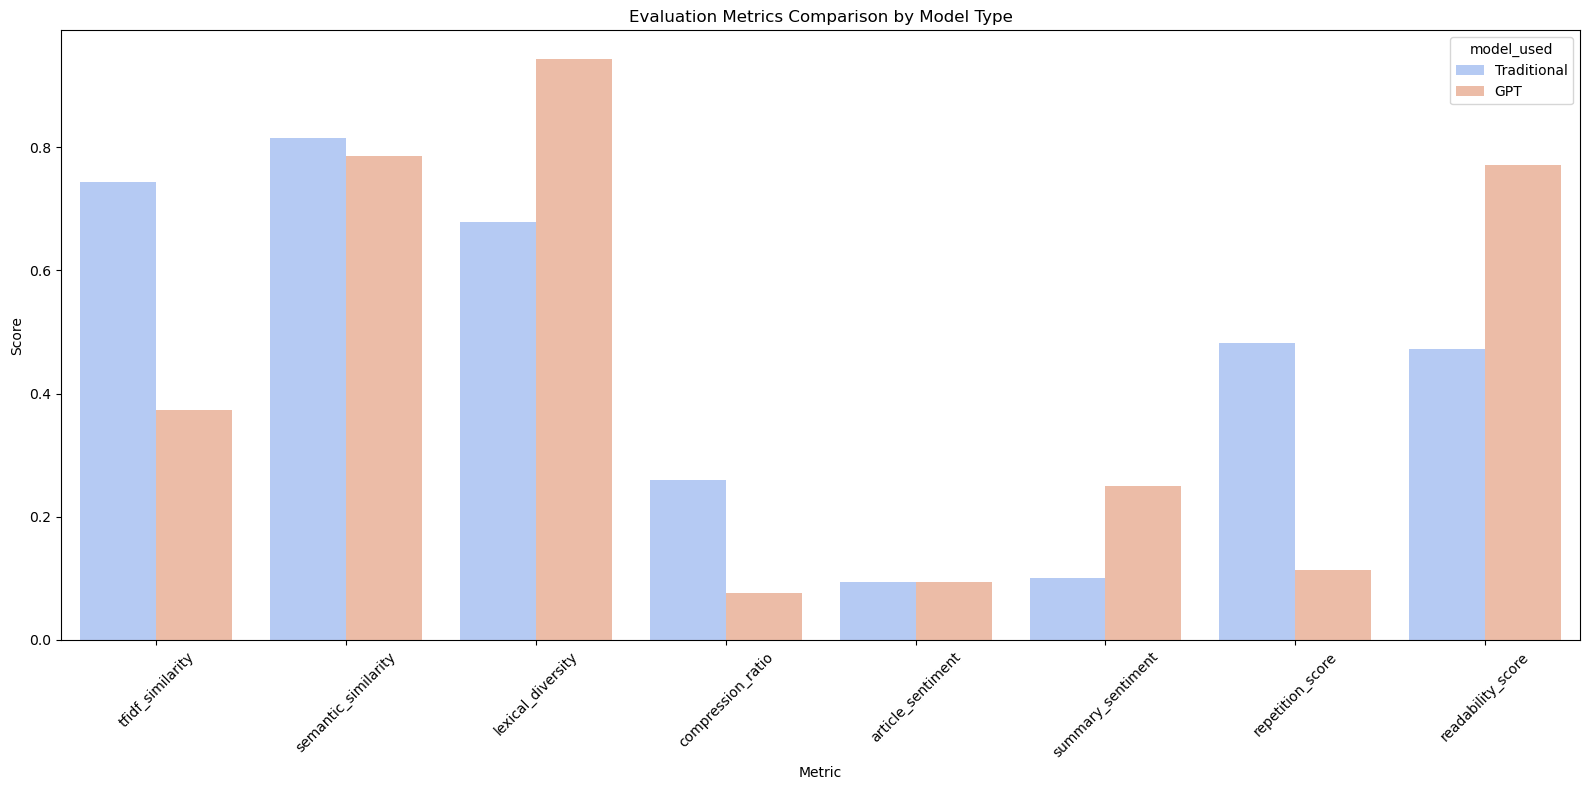

In [44]:
# visualising the evaluation metrics
import matplotlib.pyplot as plt
import seaborn as sns

metric_cols = [
    'tfidf_similarity', 'semantic_similarity', 'lexical_diversity',
    'compression_ratio', 'article_sentiment', 'summary_sentiment', 'repetition_score', 'readability_score']

melted_df = evaluation_df.melt(id_vars='model_used', value_vars=metric_cols,
                               var_name='Metric', value_name='Score')

plt.figure(figsize=(16, 8))
sns.barplot(data=melted_df, x='Metric', y='Score', hue='model_used', palette = 'coolwarm')
plt.xticks(rotation=45)
plt.title('Evaluation Metrics Comparison by Model Type')
plt.tight_layout()
plt.show()



### Insights

- **TF-IDF Similarity:**  The extractive model preserves original word usage better, leading to higher overlap with the article text. 
- **Semantic Similarity:**  Both models capture overall meaning well; GPT shows slight loss possibly due to abstraction.                
- **Lexical Diversity:** GPT generates more diverse vocabulary, which is typical of abstractive models.                              
- **Compression Ratio:** Traditional summaries are more verbose; GPT compresses content more aggressively (more concise summaries).  
- **Article Sentiment:** Base article sentiment is the same (expected).                                                              
- **Summary Sentiment** GPT may slightly change tone (more positive/subjective), while Traditional tends to copy original tone.     
- **Repetition Score:**  Traditional has more redundancy, GPT avoids repetition better (likely due to controlled generation).        
- **Readability Score:** GPT summaries are easier to read, likely more fluent and coherent.                                             

**Final Insight:**
In a whole, Traditional models are more reliable for factual accuracy and staying close to the original text. On the other hand, GPT models create more varied, natural-sounding, and easy-to-read content, which makes them better for things like chatbots and other applications that interact directly with users.
Depending on the use-case, you may prefer:
- Traditional: For fact-heavy or technical documents
- GPT: For news, blogs, or general reading where readability and flow matter more